## Feature Engineering (Continued)
We continue working with the data we left off with from `EDA_1`. The primary focus of this script is to develop a novel feature from our data that correlates well with the price of the stock in the future.
<br>
<br>
**Importing required packages & changing working directory**

In [55]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import datetime

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [56]:
stock_of_interest = "CVX"
stock_data_path = "data/EDA/"
adj_daily_closing_path = "data/adjusted_daily_closing/"
adj_daily_dividend_path = "data/dividends/"
eda_data_path = "data/EDA/"
lead_days = 5

**Load adjusted daily closing and dividend prices**

In [57]:
daily_closing = pd.read_csv(os.path.abspath(os.path.join(adj_daily_closing_path, (stock_of_interest + ".csv"))))
daily_closing["date"] = pd.to_datetime(daily_closing["date"]).dt.date

daily_dividend = pd.read_csv(os.path.abspath(os.path.join(adj_daily_dividend_path, (stock_of_interest + "_ts.csv"))))
daily_dividend["date"] = pd.to_datetime(daily_dividend["date"]).dt.date

adj_closing_df = daily_closing[["date", "close"]].merge(right=daily_dividend,
                                                        how="outer",
                                                        on="date")

adj_closing_df["adj closing"] = adj_closing_df["close"] - adj_closing_df["amount"]
adj_closing_df = adj_closing_df[["date", "adj closing"]]

**Load data file saved from `EDA_1.ipynb`**

In [58]:
calls_interest = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (stock_of_interest + "_calls_EDA1.csv"))))
calls_interest["date"] = pd.to_datetime(calls_interest["date"]).dt.date
calls_interest["expiration date"] = pd.to_datetime(calls_interest["expiration date"]).dt.date

puts_interest = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (stock_of_interest + "_puts_EDA1.csv"))))
puts_interest["date"] = pd.to_datetime(puts_interest["date"]).dt.date
puts_interest["expiration date"] = pd.to_datetime(puts_interest["expiration date"]).dt.date

**Here we attempt to create a meaningful feature based off our data**

We chose to multiply the change in interest, the price of the option, as well as the amount the stock needs to move by each day were the option to expire exactly at the "breakeven" price. We feel that each of these three features are tied to each other. For example, the price of an option does not matter if there is no volume/change in open interest. The listed "price" can happen to be very old or simply a ridiculous offer.

In [59]:
adj_closing = calls_interest.groupby(["date"]).mean()[["adj closing"]].reset_index()

calls_interest["calls senti"] = calls_interest["delta interest"] * calls_interest["price"] * calls_interest["delta price / day"]
calls_interest_day = calls_interest.groupby(["date"]).sum()[["calls senti"]].reset_index()

puts_interest["puts senti"] = puts_interest["delta interest"] * puts_interest["price"] * puts_interest["delta price / day"]
puts_interest_day = puts_interest.groupby(["date"]).sum()[["puts senti"]].reset_index()

options_senti = calls_interest_day.merge(right = puts_interest_day,
                                         how="outer",
                                         on = "date")
options_senti = options_senti.merge(right = adj_closing,
                                    how = "outer",
                                    on = "date")

end_index = int(adj_closing_df[adj_closing_df["date"] == options_senti.iloc[-1]["date"]].index.values)
lead_append = adj_closing_df.iloc[end_index  + 1: (end_index  + lead_days + 1)]

options_senti = options_senti.append(lead_append, ignore_index = True)

We want to explore how well our feature correlates with different time gaps looking forward.

In [60]:
for n in range(1, 6):
    options_senti[str("lead " + str(n))] = options_senti["adj closing"].shift(periods=-n) - \
                                           options_senti["adj closing"]

options_senti = options_senti[options_senti.notna().all(axis=1)]

**Visual Representation of Engineered Feature**

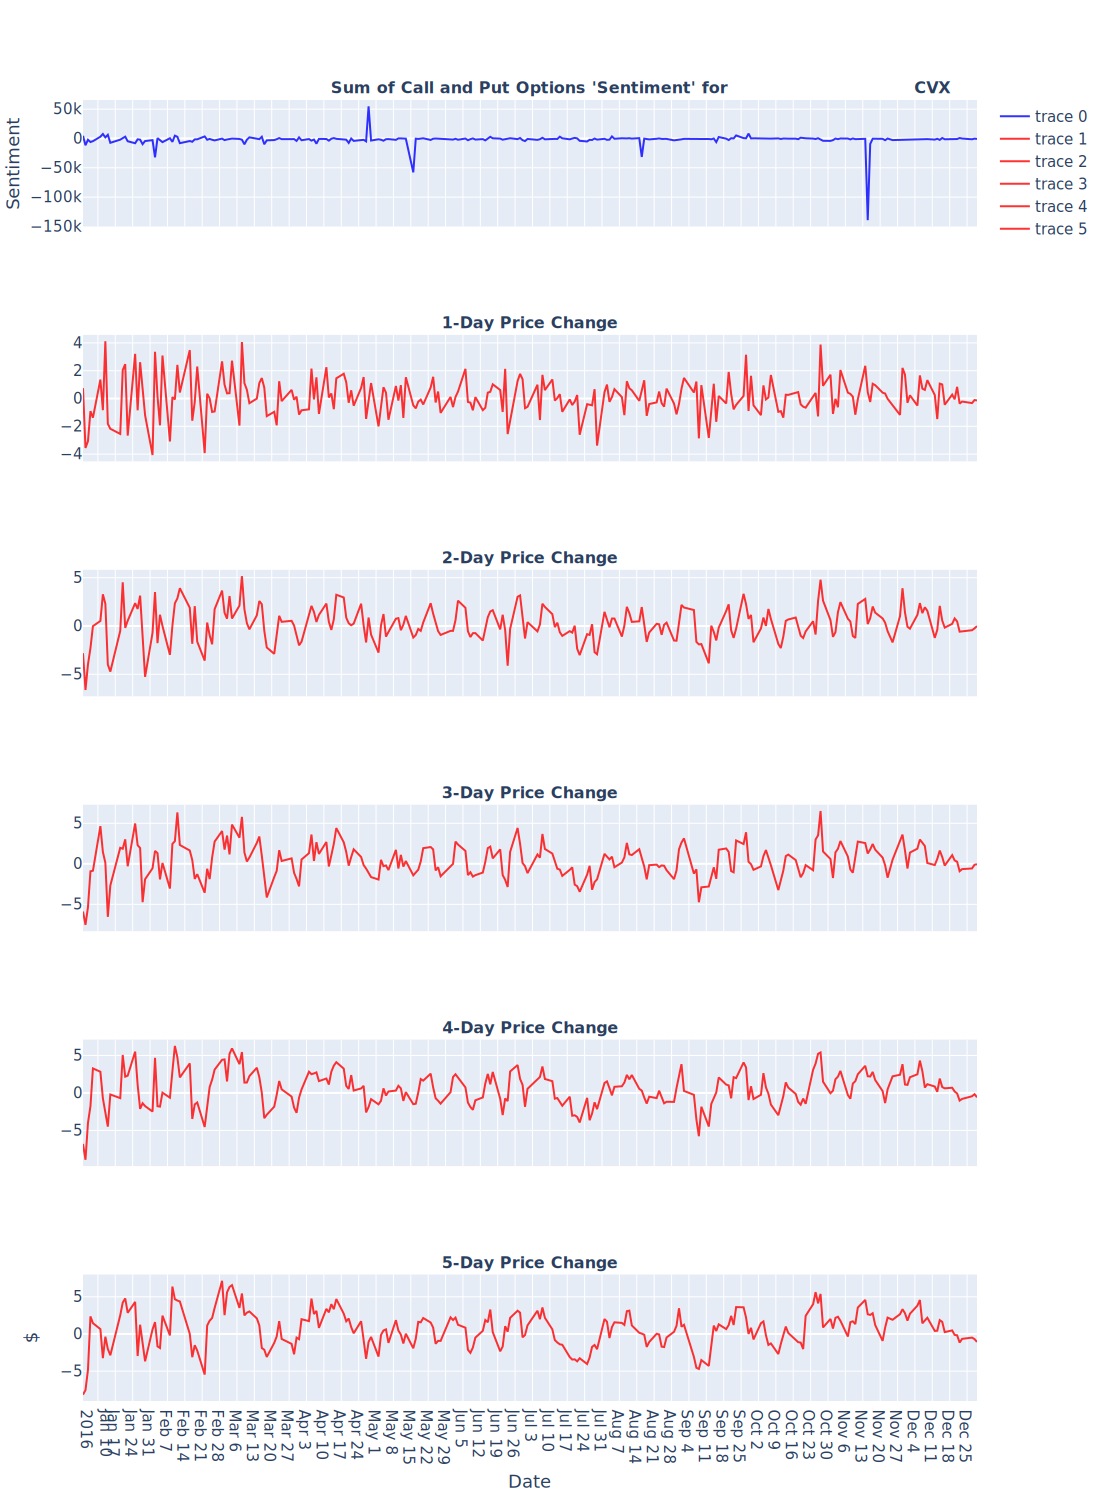

In [66]:
fig = make_subplots(rows = 6,
                    cols = 1,
                    subplot_titles=("<b>Sum of Call and Put Options 'Sentiment' for <b>" + stock_of_interest,
                                    "<b>1-Day Price Change<b>",
                                    "<b>2-Day Price Change<b>",
                                    "<b>3-Day Price Change<b>",
                                    "<b>4-Day Price Change<b>",
                                    "<b>5-Day Price Change<b>"),
                    shared_xaxes=True)

fig.add_trace(go.Scatter(
    x = options_senti["date"],
    y = options_senti["calls senti"] + options_senti["puts senti"],
    marker_color="blue",
    opacity=0.8,
    connectgaps = True),
row=1,
col=1)


for n in range(2, 7):
    fig.add_trace(go.Scatter(
        x = options_senti["date"],
        y = options_senti[str("lead " + str(n - 1))],
        marker_color="red",
        opacity=0.8,
        connectgaps = True),
    row=n,
    col=1)
    fig['layout'][str('xaxis' + str(n))]['nticks']=100

fig['layout']['yaxis']['title']='Sentiment'
fig['layout']['yaxis6']['title']='$'
fig['layout']['xaxis']['nticks']=100
fig['layout']['xaxis6']['title']="Date"

fig.update_layout(font=dict(size=15))

fig.show("svg", width=1100, height=1500)
